#Analisis de Renuncia de Empleados
Proyecto BEDU Data Science

- Andrea Mirelle Peralta Ogaz
- Adriana Hernández Sánchez
- Giselle Guadalupe González Robles
- Monica Berenice Ortiz Cardenas
- Rebeca Gutiérrez Lemus

#Introducción

El objetivo de este proyecto es realizar un analisis de datos en base a distintos datos de nuestra base de datos y obtener los resultados analizando distintas variables dentro de esta, por ejemplo, las diversidad de genero dentro de la empresa, motivos de renuncia, entre otros.

De la misma manera, la tomando decisiones inteligentes basadas en el analisis de datos, aplicar los distintos modelos estudiados dentro del curso en lenguaje de programación como por ejemplo pandas, para crear predicciones de regresión y clasificación con los datos obtenidos dentro del analisis. Para esto, se utilizarán bases de datos proporcionada por una las integrantes del equipo, incluyendo puntos geográficos, obtenidos del lugar de nacimiento y residencia del personal, para realizar su analisis.

#Instalaciones necesarias

In [ ]:
# ! pip install geopandas rtree
# ! apt install libspatialindex-dev
# ! pip install --upgrade plotly
# ! pip install pandas matplotlib openpyxl
# ! pip install nltk

!apt install libspatialindex-dev
!pip install geopandas rtree plotly pandas matplotlib openpyxl nltk
!pip install fastapi kaleido python-multipart uvicorn  # Dependencias de lida
!pip install lida
!pip install --upgrade tensorflow-probability

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libspatialindex-dev is already the newest version (1.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0


#Importación de bibliotecas

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from nltk.corpus import stopwords
from prettytable import PrettyTable
from scipy.stats import skew
from scipy.stats import kurtosis
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from collections import Counter
from nltk.probability import FreqDist
from nltk import bigrams
from IPython.display import Image


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Funciones

In [ ]:
def delete_outliers(my_serie):
  box_max = my_serie.quantile(0.75)
  box_min = my_serie.quantile(0.25)
  iqr = box_max - box_min
  middle_value = my_serie.median()
  whisker_max = box_max + iqr * 1.5
  whisker_min = box_min - iqr * 1.5
  filter = (my_serie > whisker_min)  & (my_serie < whisker_max)
  filtered = my_serie[filter]
  return filtered
def show_summary_values(my_serie):
  print(f'Mediana: {my_serie.median()}')
  print(f'Media: {my_serie.mean()}')
  print(f'Desviación std: {my_serie.std()}')
  pass
def frequency_table(my_serie,n_bins):
  segmented = pd.cut(my_serie, n_bins)
  table = my_serie.groupby(segmented).count()
  return table
def show_range(my_serie):
  my_range = my_serie.max() - my_serie.min()
  return my_range
def show_dispersion_params(my_serie):
  print(f'asimetría: {skew(my_serie)}')
  print(f'curtosis: {kurtosis(my_serie)}')
  pass

#1. Estimado de locación y variabilidad

**Tenemos un dataset con información de una empresa en Juarez, Chihuahua, sobre empleados que renunciaron de forma voluntaria:**




In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.xlsx')
df.head()

,ID,Posición,Area,Á.liq.,Grupo de personal,CODIGO POSTAL,Motivo de la RENUNCIA,Tipo de Baja,Banda,Baja,...,Alta,Antigüedad Clas,Antigüedad,Clave de sexo,Lugar de nacimiento,Clasificacion L. N,Edad del empleado,¿Cuanto tiempo tiene viviendo en Cd. Juarez?,Estado Civil,Hijos
0,1,514,7,2,2,32520,280,0,3,2023-01-02,...,2018-06-21,4,1656,0,JUAREZ,1,31,0,3,0
1,2,1745,8,1,1,32217,280,0,1,2023-01-03,...,2017-07-20,5,1993,1,DURANGO,3,25,10,3,0
2,3,1230,15,1,1,32600,280,0,1,2023-01-03,...,2019-08-29,4,1223,1,JUAREZ,1,23,10,3,0
3,4,1661,8,1,1,32575,230,0,2,2023-01-03,...,2022-11-03,1,61,0,JUAREZ,1,18,10,3,0
4,5,1921,8,1,1,32575,220,0,2,2023-01-03,...,2017-03-02,5,2133,1,JUAREZ,1,26,10,3,0


**Antes de analizar los datos, cambiamos los nombres de las columnas para que tengan el mismo formato**

In [ ]:
nuevos_nombres= ['Id', 'Posicion', 'Area', 'A_liq', 'Grupo_de_personal', 'Codigo_postal','Motivo_renuncia','Tipo_de_baja','Banda','Baja','Regla_PHT', 'Alta','Antiguedad_clas', 'Antiguedad','Clave_de_sexo','Lugar_de_nacimiento','Clasificacion_LN','Edad_empleado','Tiempo_viviendo_en_CdJuarez','Estado_civil', 'Hijos']

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.xlsx',names=nuevos_nombres)
df.head()

,Id,Posicion,Area,A_liq,Grupo_de_personal,Codigo_postal,Motivo_renuncia,Tipo_de_baja,Banda,Baja,...,Alta,Antiguedad_clas,Antiguedad,Clave_de_sexo,Lugar_de_nacimiento,Clasificacion_LN,Edad_empleado,Tiempo_viviendo_en_CdJuarez,Estado_civil,Hijos
0,1,514,7,2,2,32520,280,0,3,2023-01-02,...,2018-06-21,4,1656,0,JUAREZ,1,31,0,3,0
1,2,1745,8,1,1,32217,280,0,1,2023-01-03,...,2017-07-20,5,1993,1,DURANGO,3,25,10,3,0
2,3,1230,15,1,1,32600,280,0,1,2023-01-03,...,2019-08-29,4,1223,1,JUAREZ,1,23,10,3,0
3,4,1661,8,1,1,32575,230,0,2,2023-01-03,...,2022-11-03,1,61,0,JUAREZ,1,18,10,3,0
4,5,1921,8,1,1,32575,220,0,2,2023-01-03,...,2017-03-02,5,2133,1,JUAREZ,1,26,10,3,0


In [ ]:
df.dtypes

Id                                      int64
Posicion                                int64
Area                                    int64
A_liq                                   int64
Grupo_de_personal                       int64
Codigo_postal                           int64
Motivo_renuncia                         int64
Tipo_de_baja                            int64
Banda                                   int64
Baja                           datetime64[ns]
Regla_PHT                               int64
Alta                           datetime64[ns]
Antiguedad_clas                         int64
Antiguedad                              int64
Clave_de_sexo                           int64
Lugar_de_nacimiento                    object
Clasificacion_LN                        int64
Edad_empleado                           int64
Tiempo_viviendo_en_CdJuarez             int64
Estado_civil                            int64
Hijos                                   int64
dtype: object

Como se puede observar, la mayoría de los datos son de tipo númerico, a excepción de la columna Baja y Alta, que tienen formato datetime64, y el lugar de nacimiento que tiene formato object.

Antes de sacar media, mediana, moda, max, o min, de las columnas que nos interesan como: Motivo_de_renuncia, Antiguedad_clas, Edad_empleado, Tiempo_viviendo_en_CdJuarez, Estado_civil, e Hijos. Primero haremos diccionarios con el significado de los valores númericos de las columnas: Motivo_de_renuncia, Antiguedad_clas, y Estado_civil para comprenderlos mejor.

In [ ]:
Diccionario_Motivo_de_renuncia = {
    100:'Pensionado IMSS',
    120:'Terminación del contrato',
    130:'Ausentismos continuos',
    200:'Muerte',
    210:'Ambiente de trabajo',
    220:'Cambio de domicilio',
    230:'Estudios',
    240:'Insatisfacción personal',
    250:'Maternidad',
    260:'Matrimonio',
    270:'No regreso / no dio razón',
    280:'Otro empleo',
    290:'Prob personales y/o fam.',
    300:'Problemas con transporte',
    310:'Razones médicas',
    320:'Transferencia de planta',
    400:'Bajo desempeño',
    500:'Falsificación de documentos',
    600:'Jubilación',
    700:'LFT y/o Reglamento Int.',
    800:'Uso de drogas y/o bebi',
}


In [ ]:
Diccionario_Antiguedad_clas= {
    1:'uno a tres años',
    2:'uno a seis meses',
    3:'diez o más años',
    4:'cuatro o cinco años',
    5:'seis a diez años',
    6:'seis a once meses',
    7:'menos de un mes',
}

In [ ]:
Diccionario_Estado_civil= {
    1:'Casado',
    2:'Divorciado',
    3:'Soltero',
    4:'U.Libre',
    5:'Viudo',
}

El motivo de renuncia que más se repitió entre los empleados fue el 280, que es: Otro empleo

In [ ]:
df ['Motivo_renuncia'].mode()

0    280
Name: Motivo_renuncia, dtype: int64

El estado civil de los empleados que renunciaron que más se repitió fue el número 3, que es: Soltero

In [ ]:
df ['Estado_civil'].mode()

0    3
Name: Estado_civil, dtype: int64

El tiempo de antiguedad que más se repitió de los empleados que renunciaron fue el número 1, que es: uno a tres años

In [ ]:
df ['Antiguedad_clas'].mode()

0    1
Name: Antiguedad_clas, dtype: int64

In [ ]:
df ['Edad_empleado'].mean()

30.941553813257304

In [ ]:
df ['Edad_empleado'].median()

28.0

In [ ]:
df ['Edad_empleado'].max()

67

In [ ]:
df['Edad_empleado'].min()

18

In [ ]:
df['Edad_empleado'].describe()

count    1403.000000
mean       30.941554
std         9.734537
min        18.000000
25%        24.000000
50%        28.000000
75%        36.000000
max        67.000000
Name: Edad_empleado, dtype: float64

Se puede observar que la edad promedio de los empleados que renunciaron es de 30 años. Si aplicamos la media truncada a un porcentaje aceptable, podremos ver los valores atípicos se concentran en edades mayores que la media, es decir, la edad mas grande de renuncia es 67, mientras la media es de 30.

In [ ]:
df.loc[df['Edad_empleado']==67]

,Id,Posicion,Area,A_liq,Grupo_de_personal,Codigo_postal,Motivo_renuncia,Tipo_de_baja,Banda,Baja,...,Alta,Antiguedad_clas,Antiguedad,Clave_de_sexo,Lugar_de_nacimiento,Clasificacion_LN,Edad_empleado,Tiempo_viviendo_en_CdJuarez,Estado_civil,Hijos
888,889,2803,13,1,1,32676,600,1,1,2022-05-23,...,2007-05-07,3,5495,1,SAN LUIS POTOSI,3,67,0,1,5


El promedio recortado muestra que los valores atípicos se concentran hacia números más grandes que la media.

In [ ]:
sub = df.loc[df['Antiguedad_clas']==3]
print("Promedio de edades entre trabajadores: " + str(sub['Edad_empleado'].mean()))
print("Promedio recortado: ",end=" ")
stats.trim_mean(sub['Edad_empleado'],0.1)

Promedio de edades entre trabajadores: 45.1651376146789
Promedio recortado:  

45.20224719101124

In [ ]:
promedio = df.groupby(['Edad_empleado'], as_index = False)['Antiguedad_clas'].mean()
mediana = df.groupby(['Edad_empleado'], as_index = False)['Antiguedad_clas'].median()
maximo = df.groupby(['Edad_empleado'], as_index = False)['Antiguedad_clas'].max()
total = df.groupby(['Edad_empleado'], as_index = False)['Antiguedad_clas'].sum()

estimados = df[['Edad_empleado','Antiguedad']].drop_duplicates().reset_index()

estimados = pd.merge(estimados, promedio, on='Edad_empleado').rename(columns={'Antiguedad_clas':'Promedio'})
estimados = pd.merge(estimados, mediana, on='Edad_empleado').rename(columns={'Antiguedad_clas':'Mediana'})
estimados = pd.merge(estimados, maximo, on='Edad_empleado').rename(columns={'Antiguedad_clas':'Maximo'})
estimados = pd.merge(estimados, total, on='Edad_empleado').rename(columns={'Antiguedad_clas':'Total'})

estimados

,index,Edad_empleado,Antiguedad,Promedio,Mediana,Maximo,Total
0,0,31,1656,3.098039,3.0,7,158
1,18,31,76,3.098039,3.0,7,158
2,37,31,26,3.098039,3.0,7,158
3,62,31,39,3.098039,3.0,7,158
4,71,31,68,3.098039,3.0,7,158
...,...,...,...,...,...,...,...
1344,1367,54,3341,6.000000,6.0,7,24
1345,888,67,5495,3.000000,3.0,3,3
1346,1306,64,10552,3.000000,3.0,3,3
1347,1347,59,4847,3.000000,3.0,3,6


La desviación estándar es de 10

In [ ]:
sub['Edad_empleado'].std()

10.208487537581703

El 25% de los empleados que renunciaron tienen igual o menos de 38 años. El 50% tienen igual o menos de 44 años. Y el 75% tienen igual o menos de 55 años.

In [ ]:
print("Percentiles, Edad de los empleados:  ")
print("Percentil 25: "+str(sub['Edad_empleado'].quantile(0.25)))
print("Percentil 50: "+str(sub['Edad_empleado'].median()))
print("Percentil 75: "+str(sub['Edad_empleado'].quantile(0.75)))

Percentiles, Edad de los empleados:  
Percentil 25: 38.0
Percentil 50: 44.0
Percentil 75: 55.0


En el rango intercuartílico hay una distancia de 17 entre los valores que están más cerca a la media.


In [ ]:
sub['Edad_empleado'].quantile(0.75) - sub['Edad_empleado'].quantile(0.25)

17.0

El promedio de hijos que tienen las personas que renunciaron es de uno.

In [ ]:
df ['Hijos'].mean()

1.1325730577334283

El rango de valores de Hijos es de 6

In [ ]:
sub['Hijos'].max() - sub['Hijos'].min()

6

El promedio de tiempo viviendo en Cd. Juárez de las personas que renunciaron es de 3 años.

In [ ]:
df ['Tiempo_viviendo_en_CdJuarez'].mean()

3.9550962223806128

#2. Visualización de datos: Distribuciones

En esta sección visualizaremos la distribución de datos, en base a la antigüedad en años y el tipo de baja de los empleados.

Realizaremos:
* Distribución de datos en tipo de baja vs Antigüedad Clas.
* Filtración de datos atípicos.
* Comparación de distribuciones Antigüedad (Antigüedad días) vs Antigüedad Clas (en años).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.csv')

In [ ]:
df.head()

,ID,Posición,Area,Á.liq.,Grupo de personal,CODIGO POSTAL,Motivo de la RENUNCIA,Tipo de Baja,Banda,Baja,...,Alta,Antigüedad Clas,Antigüedad,Clave de sexo,Lugar de nacimiento,Clasificacion L. N,Edad del empleado,¿Cuanto tiempo tiene viviendo en Cd. Juarez?,Estado Civil,Hijos
0,1,POS514,LOG,S6,Exempt,32520,Vol-Otro empleo,Voluntario,E3,02/01/2023,...,21/06/2018,4 - 5 Años,1656,Femenino,JUAREZ,CIUDAD,31,Menos de un año,Soltero,0
1,2,POS1745,MFS,S5,Direct,32217,Vol-Otro empleo,Voluntario,DNO,03/01/2023,...,20/07/2017,6 - 10 Años,1993,Masculino,DURANGO,PAIS,25,10+ Years,Soltero,0
2,3,POS1230,VS7,S5,Direct,32600,Vol-Otro empleo,Voluntario,DNO,03/01/2023,...,29/08/2019,4 - 5 Años,1223,Masculino,JUAREZ,CIUDAD,23,10+ Years,Soltero,0
3,4,POS1661,MFS,S5,Direct,32575,Vol-Estudios,Voluntario,DO,03/01/2023,...,03/11/2022,1 - 3 Años,61,Femenino,CIUDAD JUAREZ,CIUDAD,18,10+ Years,Soltero,0
4,5,POS1921,MFS,S5,Direct,32575,Vol-Cambio de domicilio,Voluntario,DO,03/01/2023,...,02/03/2017,6 - 10 Años,2133,Masculino,JUAREZ,CIUDAD,26,10+ Years,Soltero,0


**Realizamos el procesamiento y analisis de datos, en base a la antigüedad trabajada en días.**

In [ ]:
antiguedad_dias = df['Antigüedad']

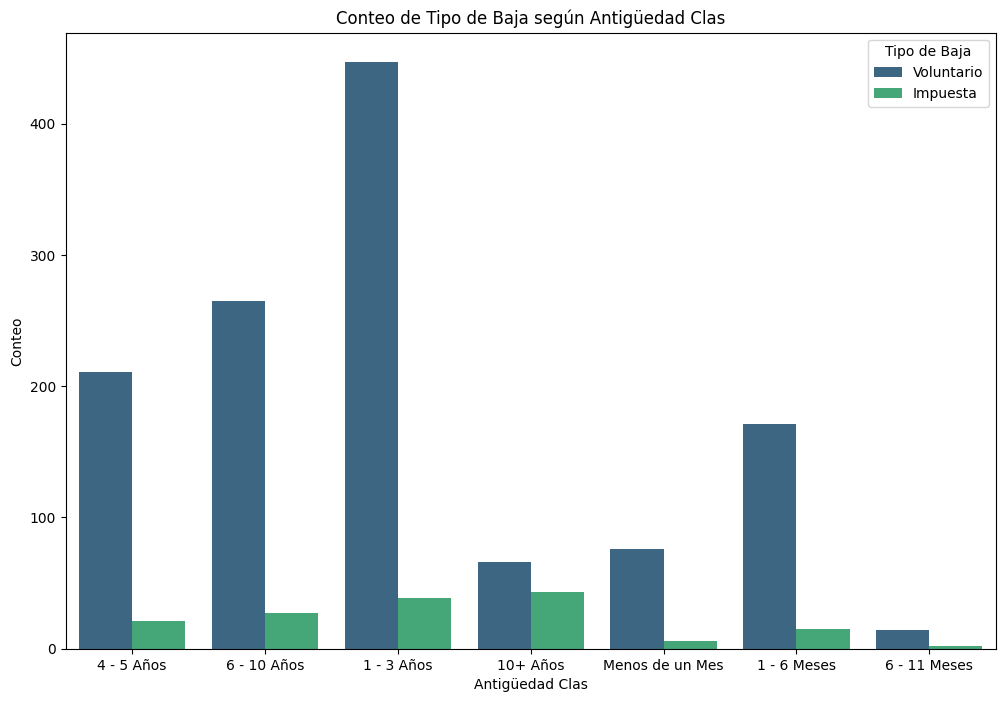

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Antigüedad Clas', hue='Tipo de Baja', data=df, palette='viridis')
plt.title('Conteo de Tipo de Baja según Antigüedad Clas')
plt.xlabel('Antigüedad Clas')
plt.ylabel('Conteo')
plt.legend(title='Tipo de Baja', loc='upper right')
plt.show()

Esta grafica de barras permite visualizar de una manera mas fácil, cómo se distribuyen las categorías de "Tipo de baja" para cada categoría de "Antigüedad Clas" (años de antigüedad) y la leyenda nos proporciona información adicional sobre el tipo de baja asociado a cada categoría de antigüedad.

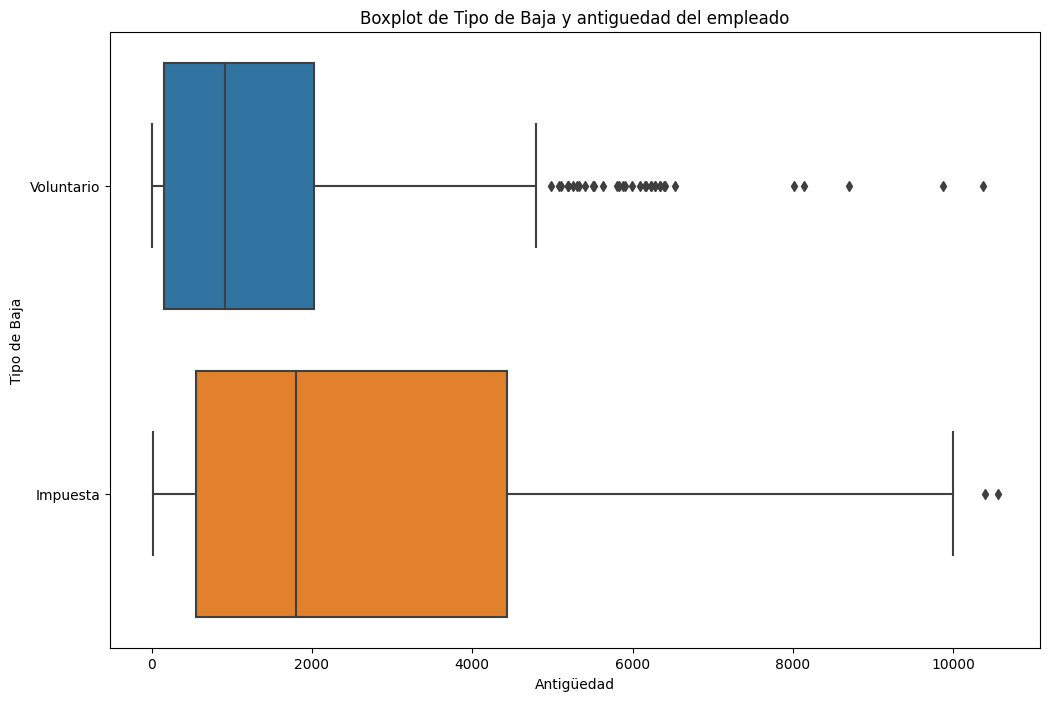

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Antigüedad', y='Tipo de Baja', data=df)
plt.title('Boxplot de Tipo de Baja y antiguedad del empleado')
plt.xlabel('Antigüedad')
plt.ylabel('Tipo de Baja')
plt.show()

La línea dentro de cada caja representa la mediana de la antigüedad para cada tipo de baja. La caja en si misma muestra el rango intercuartílico, que abarca desde el primer cuartil hasta el tercer cuartil.

Los puntos fuera de las cajas (outliers) indican valores atípicos/inusuales en la distribución, en el boxplot de tipo de baja voluntaria, se encuentran mas valores atipícos que en el boxplot de baja impuesta.

En este caso, se podrían filtrar los datos atipicos para tener una mejor visualización de su distribución.

datos ANTES del filtro:
Mediana: 978.0
Media: 1465.4511760513185
Desviación std: 1622.2803035583966

datos DESPUÉS del filtro:
Mediana: 908.0
Media: 1220.7938760268858
Desviación std: 1158.012644505842



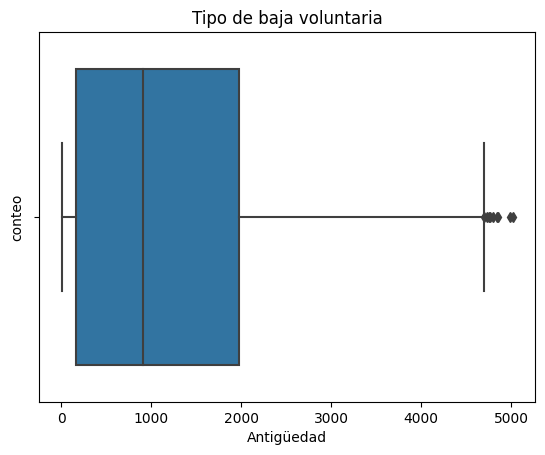

In [ ]:
antiguedad_dias_filtered = delete_outliers(antiguedad_dias)
print('datos ANTES del filtro:')
show_summary_values(antiguedad_dias)
sns.boxplot(x=antiguedad_dias_filtered).set(title='Tipo de baja voluntaria',xlabel='Antigüedad',ylabel='conteo');
print('\ndatos DESPUÉS del filtro:')
show_summary_values(antiguedad_dias_filtered)
print()

La distribución después de ser filtrada, permaneció sustancialmente igual, pero ahora podemos visualizar un poco mejor sus distribuciones.

**Procedemos a crear nuestra tabla de frecuencia con los primeros 10 datos y posteriormente realizar un histograma.**

In [ ]:
frequency_table(antiguedad_dias_filtered,20)

Antigüedad
(-0.014, 255.7]     406
(255.7, 506.4]      110
(506.4, 757.1]       88
(757.1, 1007.8]     111
(1007.8, 1258.5]     67
(1258.5, 1509.2]     70
(1509.2, 1759.9]     86
(1759.9, 2010.6]     81
(2010.6, 2261.3]     67
(2261.3, 2512.0]     48
(2512.0, 2762.7]     37
(2762.7, 3013.4]     43
(3013.4, 3264.1]     41
(3264.1, 3514.8]     26
(3514.8, 3765.5]     17
(3765.5, 4016.2]      9
(4016.2, 4266.9]     11
(4266.9, 4517.6]      7
(4517.6, 4768.3]      8
(4768.3, 5019.0]      6
Name: Antigüedad, dtype: int64

<Figure size 1200x800 with 0 Axes>

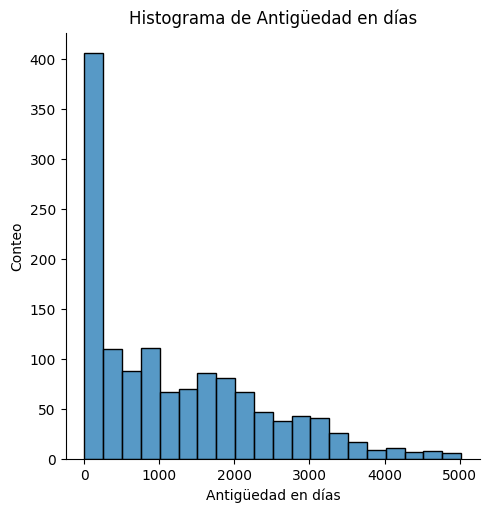

In [ ]:
# Visualización con displot
plt.figure(figsize=(12, 8))
sns.displot(antiguedad_dias_filtered, kde=False, stat='count', bins=20)
plt.title('Histograma de Antigüedad en días')
plt.xlabel('Antigüedad en días')
plt.ylabel('Conteo')
plt.show()

In [ ]:
show_dispersion_params(antiguedad_dias_filtered)

asimetría: 0.9042123521989763
curtosis: 0.04256803490388483


Después de visualizar los resultados en el histograma y los valores de asimetría y curtosis, podemos concluir que la asimetría sugiere que la distribución de la 'antigüedad en días', tiene una cola positiva, lo que significa que hay más valores concentrados en la parte izquierda de la distribución, y se extiende más hacia la derecha.

Mientras que la curtosis, es relativamente baja (0.0425), la distribución no es muy puntiaguda ni muy achatada, es decir que, la distribución tiene una forma más cercana a una distribución normal.

Ahora, separaremos datos por estados, para comparar sus distribuciones:

In [ ]:
antiguedad_años = df['Antigüedad Clas'].unique().tolist()
antiguedad_años

['4 - 5 Años',
 '6 - 10 Años',
 '1 - 3 Años',
 '10+ Años',
 'Menos de un Mes',
 '1 - 6 Meses',
 '6 - 11 Meses']

In [ ]:
cuatro_a_cinco = df[df['Antigüedad Clas'] == antiguedad_años[0]]['Antigüedad']
seis_a_diez = df[df['Antigüedad Clas'] == antiguedad_años[1]]['Antigüedad']
uno_a_tres = df[df['Antigüedad Clas'] == antiguedad_años[2]]['Antigüedad']
mas_de_diez = df[df['Antigüedad Clas'] == antiguedad_años[3]]['Antigüedad']
menos_de_un_mes = df[df['Antigüedad Clas'] == antiguedad_años[4]]['Antigüedad']
uno_a_seis_neses = df[df['Antigüedad Clas'] == antiguedad_años[5]]['Antigüedad']
seis_a_once_meses = df[df['Antigüedad Clas'] == antiguedad_años[6]]['Antigüedad']

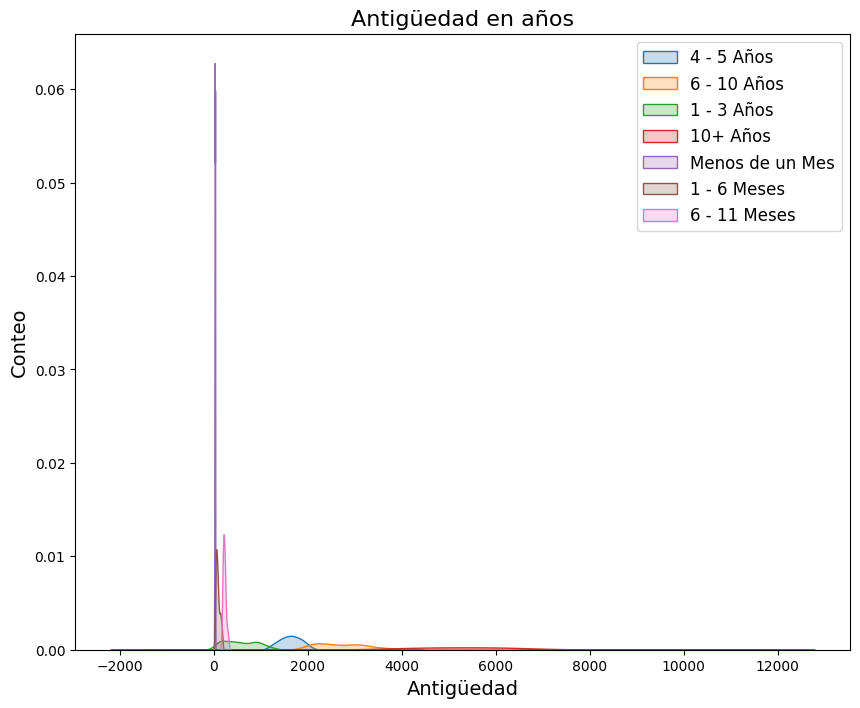

In [ ]:
plt.figure(figsize=(10, 8))

# Utilizar kdeplot en lugar de distplot
ax = sns.kdeplot(cuatro_a_cinco, fill=True, label=antiguedad_años[0])
sns.kdeplot(seis_a_diez, fill=True, label=antiguedad_años[1])
sns.kdeplot(uno_a_tres, fill=True, label=antiguedad_años[2])
sns.kdeplot(mas_de_diez, fill=True, label=antiguedad_años[3])
sns.kdeplot(menos_de_un_mes, fill=True, label=antiguedad_años[4])
sns.kdeplot(uno_a_seis_neses, fill=True, label=antiguedad_años[5])
sns.kdeplot(seis_a_once_meses, fill=True, label=antiguedad_años[6])

# Ajustar el tamaño de la fuente y otros elementos
ax.set_title('Antigüedad en años', fontsize=16)
ax.set_xlabel('Antigüedad', fontsize=14)
ax.set_ylabel('Conteo', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

plt.show()


 En este grafico visualizamos la distribución de las categorías de antigüedad en años utilizando curvas de densidad de kernel.
 * Cada curva representa la distribución estimada de la antigüedad para una categoría específica.
 * Las distribuciones varían entre las diferentes categorías y obtener la información sobre la concentración y forma de las curvas KDE para cada grupo de antigüedad.


#3. Exploración de Variables Categóricas y Análisis Multivariable

En esta seccion Exploraremos la **DIVERSIDAD, TENDENCIAS
SALARIALES Y EQUIDAD**

Esto con el fin de verificar que tan desproporcionada o porporcionada esta la cantidad de personal en la empresa respecto al Genero (Femenino o Masculino)


Para esto se hara una comparacion.

*   Clave de sexo vs Area
*   Clave de sexo vs Grupo de Personal
*   Clave de sexo vs Banda




**Procesamiento y analisis de datos**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.csv')
df.head()

,ID,Posición,Area,Á.liq.,Grupo de personal,CODIGO POSTAL,Motivo de la RENUNCIA,Tipo de Baja,Banda,Baja,...,Alta,Antigüedad Clas,Antigüedad,Clave de sexo,Lugar de nacimiento,Clasificacion L. N,Edad del empleado,¿Cuanto tiempo tiene viviendo en Cd. Juarez?,Estado Civil,Hijos
0,1,POS514,LOG,S6,Exempt,32520,Vol-Otro empleo,Voluntario,E3,02/01/2023,...,21/06/2018,4 - 5 Años,1656,Femenino,JUAREZ,CIUDAD,31,Menos de un año,Soltero,0
1,2,POS1745,MFS,S5,Direct,32217,Vol-Otro empleo,Voluntario,DNO,03/01/2023,...,20/07/2017,6 - 10 Años,1993,Masculino,DURANGO,PAIS,25,10+ Years,Soltero,0
2,3,POS1230,VS7,S5,Direct,32600,Vol-Otro empleo,Voluntario,DNO,03/01/2023,...,29/08/2019,4 - 5 Años,1223,Masculino,JUAREZ,CIUDAD,23,10+ Years,Soltero,0
3,4,POS1661,MFS,S5,Direct,32575,Vol-Estudios,Voluntario,DO,03/01/2023,...,03/11/2022,1 - 3 Años,61,Femenino,CIUDAD JUAREZ,CIUDAD,18,10+ Years,Soltero,0
4,5,POS1921,MFS,S5,Direct,32575,Vol-Cambio de domicilio,Voluntario,DO,03/01/2023,...,02/03/2017,6 - 10 Años,2133,Masculino,JUAREZ,CIUDAD,26,10+ Years,Soltero,0


In [ ]:
df_agrupado = df.groupby('Clave de sexo')

**Calculando el numero de personas por sexo**



In [ ]:
df_agrupado.size()

Clave de sexo
Femenino     709
Masculino    694
dtype: int64

Se concluye que **740 personas de la base de datos son del sexo femenino y 610 masculino**, por lo que el sexo predominante es el femenino.


**Sexo vs área**

Para conocer el número y nombre de las categorías en la columna área.

In [ ]:
df['Area'].nunique()

16

In [ ]:
df['Area'].unique()

array(['LOG', 'MFS', 'VS7', 'VS1', 'VS9-ABS', 'TEF', 'VS4', 'VS5',
       'VS1-HOUS', 'QMM', 'HRL', 'CTG', 'DBE', 'HSE', 'Admin MSE2',
       'Admin MSE1'], dtype=object)

In [ ]:
df.groupby('Clave de sexo')['Area'].value_counts()

Clave de sexo  Area      
Femenino       VS9-ABS       193
               MFS           147
               VS7            99
               VS1            78
               VS5            72
               TEF            30
               VS4            27
               VS1-HOUS       20
               LOG            16
               QMM             9
               HRL             8
               CTG             4
               HSE             3
               Admin MSE1      1
               Admin MSE2      1
               DBE             1
Masculino      MFS           139
               VS9-ABS       127
               VS7            93
               LOG            81
               VS4            61
               VS5            60
               TEF            58
               VS1            45
               QMM            10
               VS1-HOUS        7
               CTG             4
               DBE             4
               HRL             2
               HS

**Contando el número de personas por sexo en cada categoría**

Tablas de contingencia

In [ ]:
crosstab = pd.crosstab(df['Clave de sexo'], df['Area'])
crosstab

Area,Admin MSE1,Admin MSE2,CTG,DBE,HRL,HSE,LOG,MFS,QMM,TEF,VS1,VS1-HOUS,VS4,VS5,VS7,VS9-ABS
Clave de sexo,,,,,,,,,,,,,,,,
Femenino,1,1,4,1,8,3,16,147,9,30,78,20,27,72,99,193
Masculino,0,1,4,4,2,2,81,139,10,58,45,7,61,60,93,127


Se muestra de manera organizada el conteo de cada categoría por sexo

Vizualizando los totales

In [ ]:
pd.crosstab(df['Clave de sexo'], df['Area'], margins=True, margins_name="Total")

Area,Admin MSE1,Admin MSE2,CTG,DBE,HRL,HSE,LOG,MFS,QMM,TEF,VS1,VS1-HOUS,VS4,VS5,VS7,VS9-ABS,Total
Clave de sexo,,,,,,,,,,,,,,,,,
Femenino,1,1,4,1,8,3,16,147,9,30,78,20,27,72,99,193,709
Masculino,0,1,4,4,2,2,81,139,10,58,45,7,61,60,93,127,694
Total,1,2,8,5,10,5,97,286,19,88,123,27,88,132,192,320,1403


Complementando se muestran los totales de cada categoría, así como el total de empleados del sexo masculino y femenino.

**Graficando la tabla de contingencia**

Text(0.5, 0.98, 'Personas del sexo masculino y femenino trabajando por area')

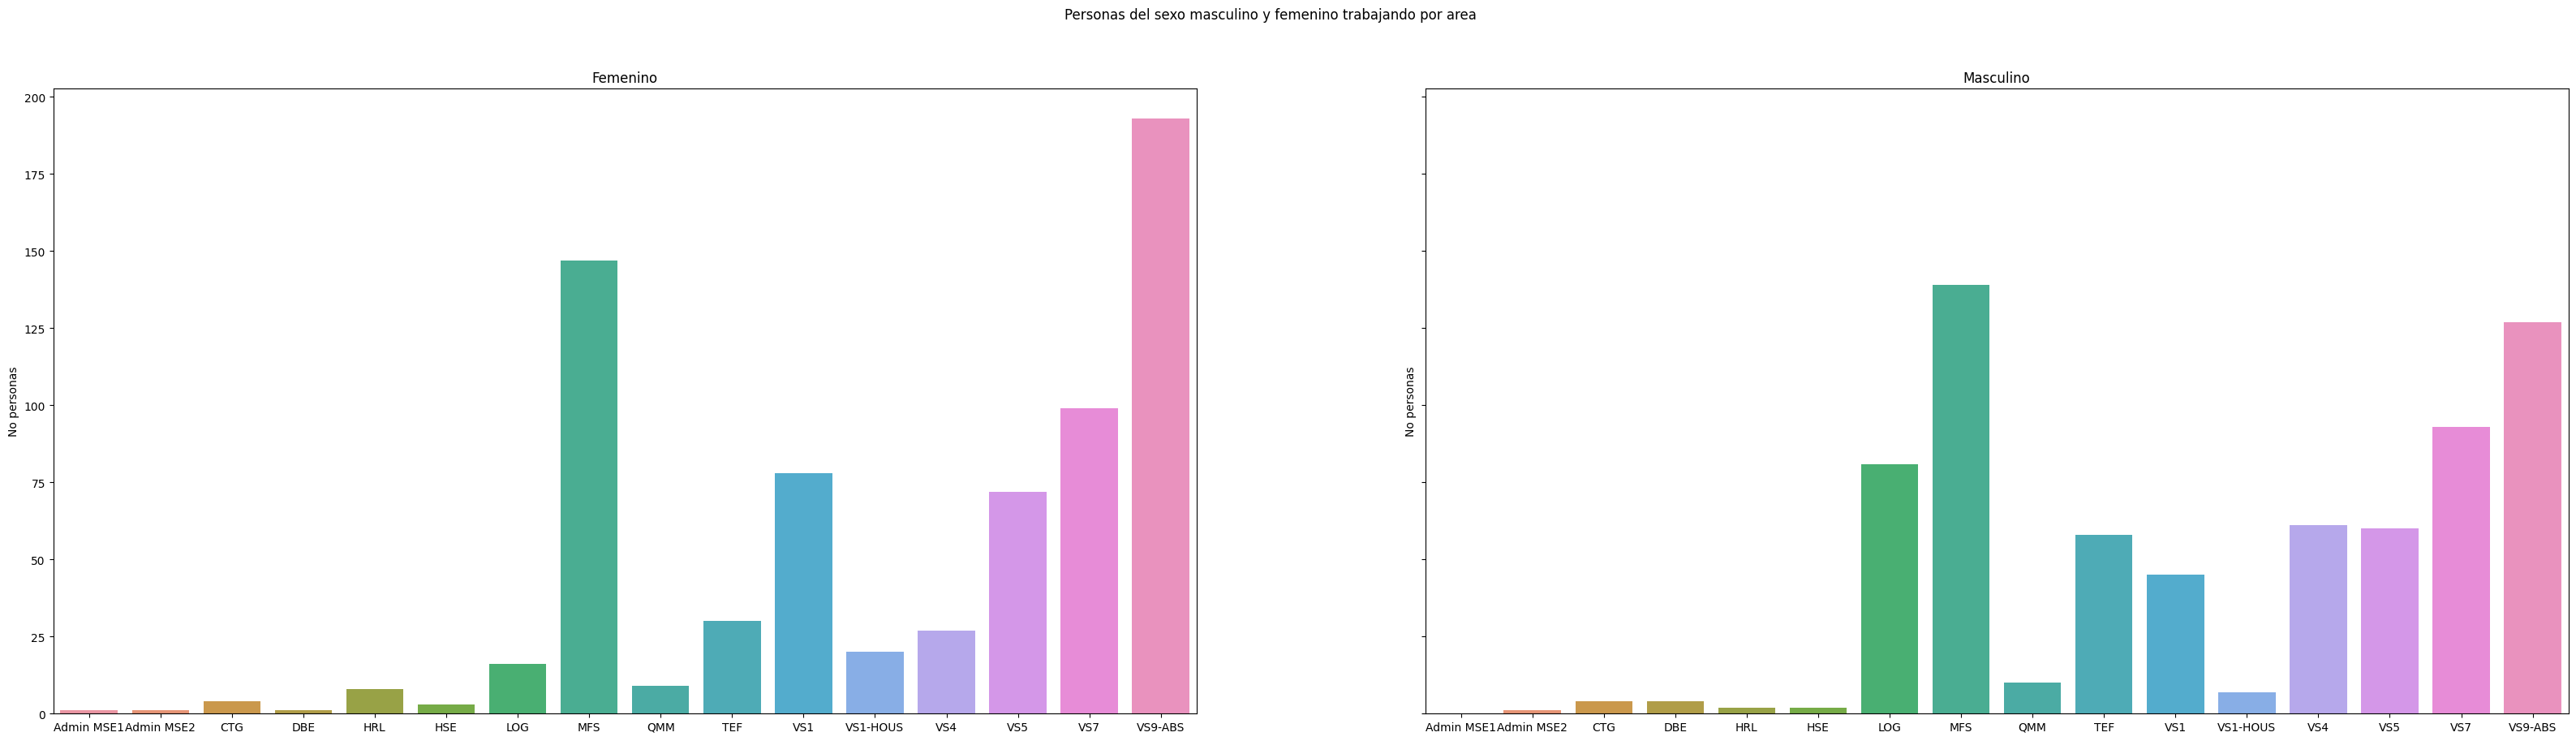

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(40,10), sharex=True, sharey=True)

sns.barplot(x=crosstab.columns, y=crosstab.loc['Femenino'], ax=axes[0])
sns.barplot(x=crosstab.columns, y=crosstab.loc['Masculino'], ax=axes[1])

axes[0].set(xlabel='', ylabel='No personas', title="Femenino")
axes[1].set(xlabel='', ylabel='No personas', title="Masculino")

fig.suptitle("Personas del sexo masculino y femenino trabajando por area")

*   Las áreas MFS, VS1, VS5, VS5 y VS9-ABS son las que cuentan con mayor número de empleados.
*   El área MFS y VS7 son las que tienen un número similar de empleados femeninos y masculinos.
*   Se muestra una diferencia significativa en el área VS9-ABS, siendo superior el número de personas femeninas.
*   Se muestra una diferencia significativa en el área LOG, siendo superior el número de personas masculinas.
*   Considerando los totales se concluyé que el personal femenino y masculino es equitativo en cuanto al numero de personas en la base de datos.

**Sexo vs grupo de personal**

Para conocer el numero y nombre de las categorias en la columna grupo de personal

In [ ]:
df['Grupo de personal'].nunique()

5

In [ ]:
df['Grupo de personal'].unique()

array(['Exempt', 'Direct', 'Indirect', 'Managers', 'Non-Exempt'],
      dtype=object)

Contando el numero de personas por sexo en cada categoria

In [ ]:
df.groupby('Clave de sexo')['Grupo de personal'].value_counts()

Clave de sexo  Grupo de personal
Femenino       Direct               648
               Exempt                46
               Indirect               8
               Managers               5
               Non-Exempt             2
Masculino      Direct               583
               Exempt                93
               Indirect              10
               Managers               8
Name: Grupo de personal, dtype: int64

**Tabla de contingencia**

In [ ]:
crosstab_1 = pd.crosstab(df['Clave de sexo'], df['Grupo de personal'])
crosstab_1

Grupo de personal,Direct,Exempt,Indirect,Managers,Non-Exempt
Clave de sexo,,,,,
Femenino,648,46,8,5,2
Masculino,583,93,10,8,0


Vizualizando los totales

In [ ]:
pd.crosstab(df['Clave de sexo'], df['Grupo de personal'], margins=True, margins_name="Total")

Grupo de personal,Direct,Exempt,Indirect,Managers,Non-Exempt,Total
Clave de sexo,,,,,,
Femenino,648,46,8,5,2,709
Masculino,583,93,10,8,0,694
Total,1231,139,18,13,2,1403


**Graficando la tabla de contingencia**

Text(0.5, 0.98, 'Personas del sexo masculino y femenino trabajando por grupo de personal')

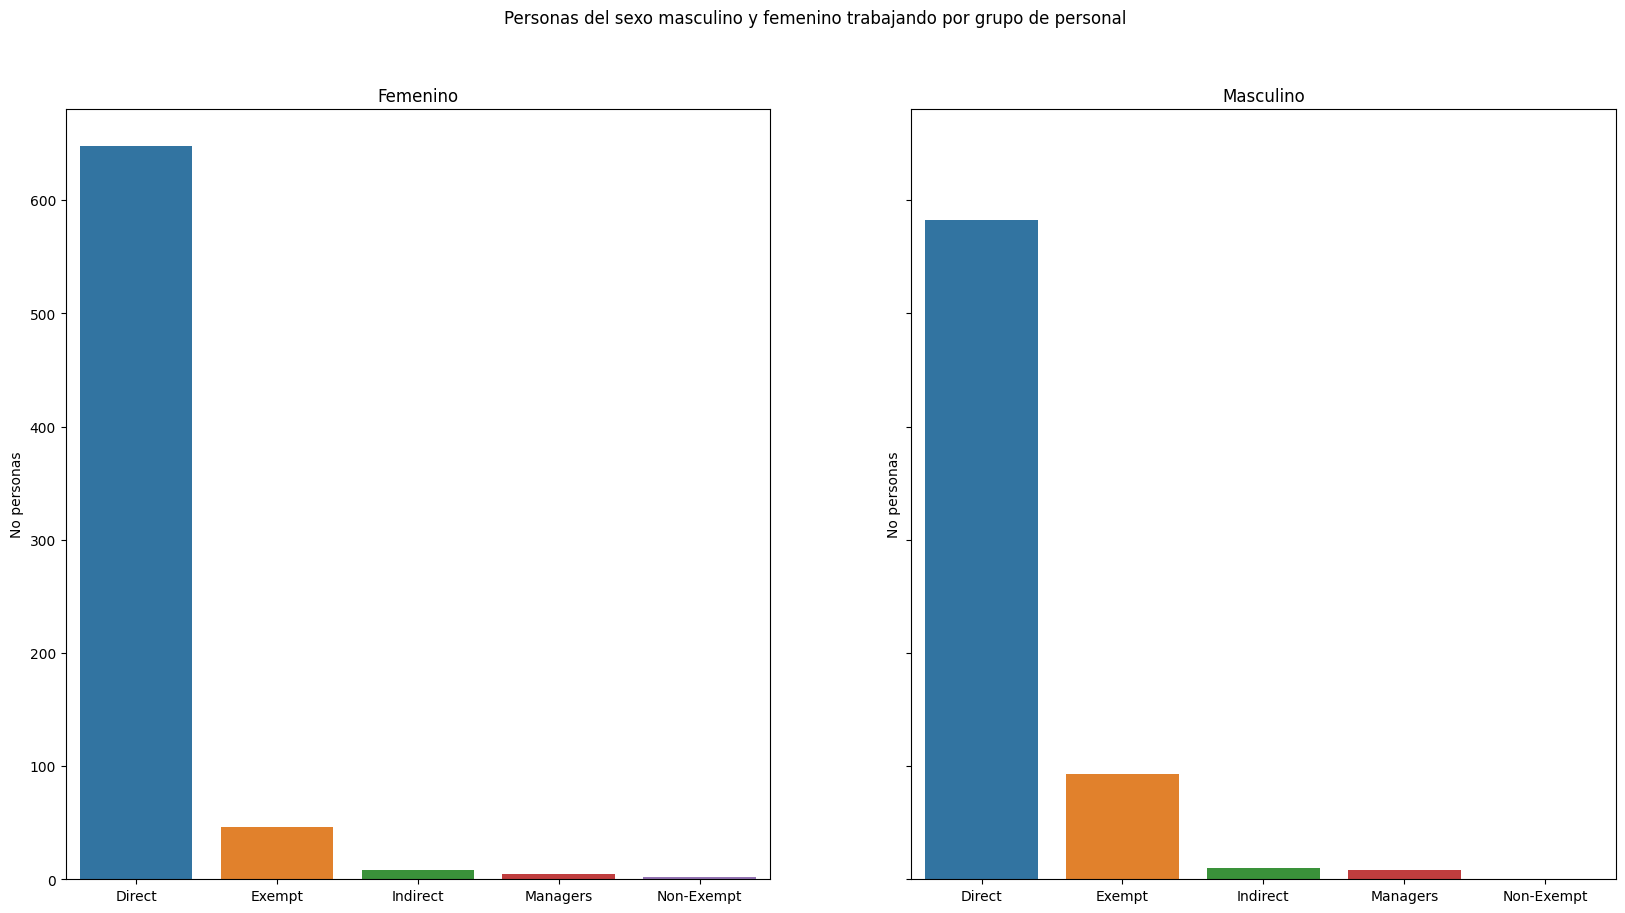

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)

sns.barplot(x=crosstab_1.columns, y=crosstab_1.loc['Femenino'], ax=axes[0])
sns.barplot(x=crosstab_1.columns, y=crosstab_1.loc['Masculino'], ax=axes[1])

axes[0].set(xlabel='', ylabel='No personas', title="Femenino")
axes[1].set(xlabel='', ylabel='No personas', title="Masculino")

fig.suptitle("Personas del sexo masculino y femenino trabajando por grupo de personal")

*   El 52.6% del personal directo es femenino
*   El personal masculino excento representa el doble del personal femenino del mismo grupo de personal.
*   El personal indirecto no presenta una diferencia significativa.
*   El 60% de los gerentes son del sexo masculino.
*   Únicamente hay personal femenino como empleados no excentos.

**Sexo vs banda**

Para conocer el numero y nombre de las categorias en la columna banda

In [ ]:
df['Banda'].nunique()

5

In [ ]:
df['Banda'].unique()

array(['E3', 'DNO', 'DO', 'E4', 'SL1'], dtype=object)

Contando el numero de personas por sexo en cada Banda

In [ ]:
df.groupby('Clave de sexo')['Banda'].value_counts()

Clave de sexo  Banda
Femenino       DO       585
               DNO       71
               E3        32
               E4        16
               SL1        5
Masculino      DO       297
               DNO      291
               E3        65
               E4        33
               SL1        8
Name: Banda, dtype: int64

**Tabla de Contingencia**

In [ ]:
crosstab_2 = pd.crosstab(df['Clave de sexo'], df['Banda'])
crosstab_2

Banda,DNO,DO,E3,E4,SL1
Clave de sexo,,,,,
Femenino,71,585,32,16,5
Masculino,291,297,65,33,8


In [ ]:
crosstab_totalbanda = pd.crosstab(df['Clave de sexo'], df['Banda'], margins=True, margins_name="Total")
crosstab_totalbanda

Banda,DNO,DO,E3,E4,SL1,Total
Clave de sexo,,,,,,
Femenino,71,585,32,16,5,709
Masculino,291,297,65,33,8,694
Total,362,882,97,49,13,1403


**Graficando la tabla de contingencia**

Text(0.5, 0.98, 'Personas del sexo masculino y femenino trabajando por Banda')

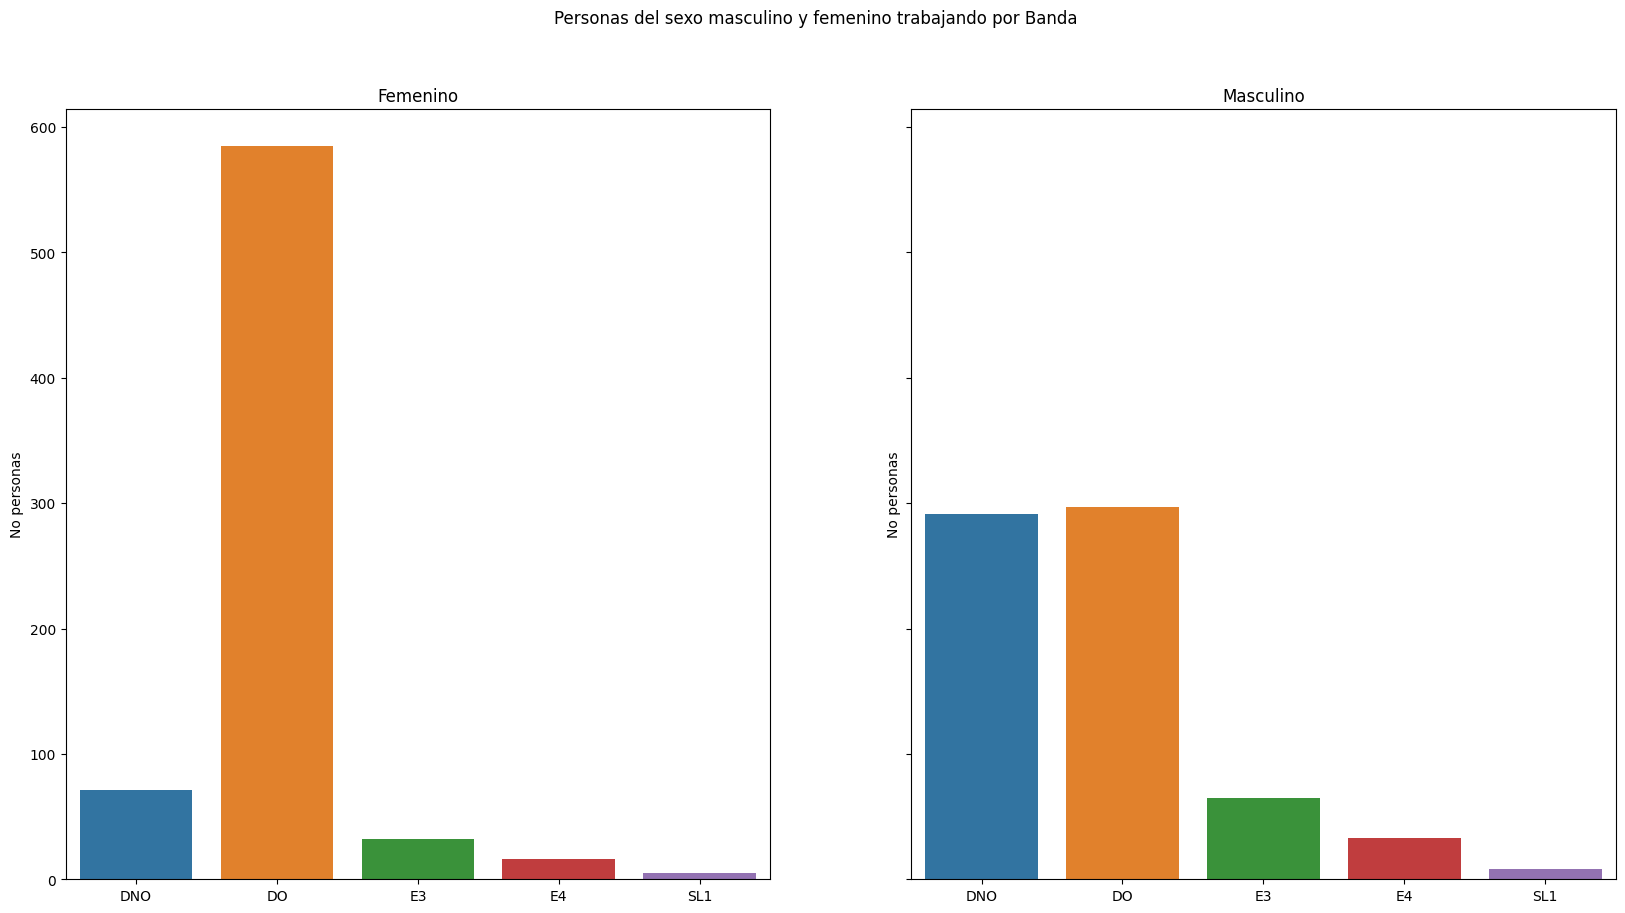

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=True)

sns.barplot(x=crosstab_2.columns, y=crosstab_2.loc['Femenino'], ax=axes[0])
sns.barplot(x=crosstab_2.columns, y=crosstab_2.loc['Masculino'], ax=axes[1])

axes[0].set(xlabel='', ylabel='No personas', title="Femenino")
axes[1].set(xlabel='', ylabel='No personas', title="Masculino")

fig.suptitle("Personas del sexo masculino y femenino trabajando por Banda")

Con respecto a las bandas salariales tenemos que:
*   En la banda DNO, la cantidad de personal masculino representa un poco más de cuatro veces el personal femenino.
*   En la banda DO, el personas femenino es casi el doble que el personal masculino.
*   Caso contrario a la banda anterior, en la banda E3 el personal masculino presenta el doble de empleados en comparación con el personal femenino.
*   En la banda E4, el personal masculino se coloca por delante con el doble de personas.
*   En la banda SL1 la diferencia entre personal masculino y femenino no es significativa.

Distribucion Categorica

#4. Correlaciones y Regresión Linear Simple

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.csv')
df.head()

,ID,Posición,Area,Á.liq.,Grupo de personal,CODIGO POSTAL,Motivo de la RENUNCIA,Tipo de Baja,Banda,Baja,...,Alta,Antigüedad Clas,Antigüedad,Clave de sexo,Lugar de nacimiento,Clasificacion L. N,Edad del empleado,¿Cuanto tiempo tiene viviendo en Cd. Juarez?,Estado Civil,Hijos
0,1,POS514,LOG,S6,Exempt,32520,Vol-Otro empleo,Voluntario,E3,02/01/2023,...,21/06/2018,4 - 5 Años,1656,Femenino,JUAREZ,CIUDAD,31,Menos de un año,Soltero,0
1,2,POS1745,MFS,S5,Direct,32217,Vol-Otro empleo,Voluntario,DNO,03/01/2023,...,20/07/2017,6 - 10 Años,1993,Masculino,DURANGO,PAIS,25,10+ Years,Soltero,0
2,3,POS1230,VS7,S5,Direct,32600,Vol-Otro empleo,Voluntario,DNO,03/01/2023,...,29/08/2019,4 - 5 Años,1223,Masculino,JUAREZ,CIUDAD,23,10+ Years,Soltero,0
3,4,POS1661,MFS,S5,Direct,32575,Vol-Estudios,Voluntario,DO,03/01/2023,...,03/11/2022,1 - 3 Años,61,Femenino,CIUDAD JUAREZ,CIUDAD,18,10+ Years,Soltero,0
4,5,POS1921,MFS,S5,Direct,32575,Vol-Cambio de domicilio,Voluntario,DO,03/01/2023,...,02/03/2017,6 - 10 Años,2133,Masculino,JUAREZ,CIUDAD,26,10+ Years,Soltero,0


Para poder cubir este punto definiremos un DataFrame solo con los Datos numericos, en este caso Antiguedad y Edad del empleado para ver si hay alguna correlacion entre los datos.

Esto debido a que la mayoria de nuestros datos son Categoricos y no son aptos para este tipo de analisis.


In [ ]:
df_filtrado = df.drop(columns=['ID','ReglaPHT','Posición','Area','Á.liq.','Grupo de personal','CODIGO POSTAL','Motivo de la RENUNCIA','Tipo de Baja','Banda',	'Baja','Alta','Antigüedad Clas', 'Clave de sexo',	'Lugar de nacimiento','Clasificacion L. N',	'¿Cuanto tiempo tiene viviendo en Cd. Juarez?',	'Estado Civil',	'Hijos'])

In [ ]:
df_filtrado

,Antigüedad,Edad del empleado
0,1656,31
1,1993,25
2,1223,23
3,61,18
4,2133,26
...,...,...
1398,4128,44
1399,2547,28
1400,43,21
1401,1982,45


Matriz de correlacion

In [ ]:
df_filtrado.corr()

,Antigüedad,Edad del empleado
Antigüedad,1.000000,0.508541
Edad del empleado,0.508541,1.000000


Mapa de Calor

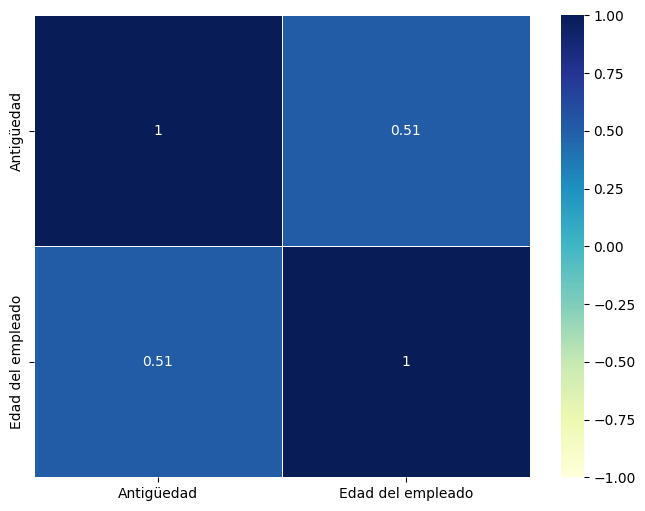

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_filtrado.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);

<Axes: xlabel='Antigüedad', ylabel='Edad del empleado'>

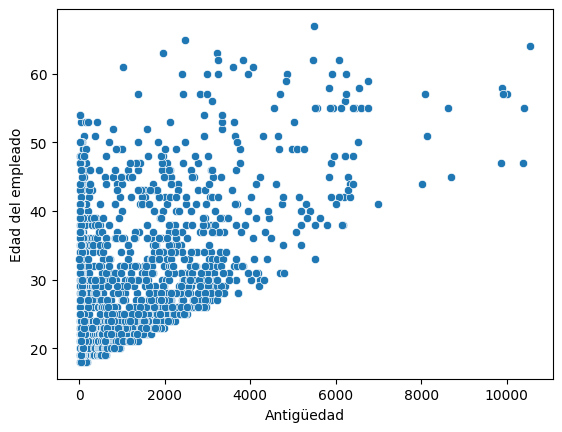

In [ ]:
sns.scatterplot(x= df_filtrado['Antigüedad'],y=df_filtrado['Edad del empleado'])

Podemos observar que en los datos hay algunos puntos alejados de la mayoria de datos, mas sin embargo estamos hablando de Antiguedad y Edad de el empleado, el cual probablemente pudiera afectar si hacemos un filtrado de esos datos, debido que es normal que a mayor edad, el empleado tenga mas antiguedad

**Regresion lineal simple**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
df_filtrado['Antigüedad'].corr(df_filtrado['Edad del empleado'])

0.5085408252613405

Podemos notar que la correlacion entre Aniguedad y Edad del empleado es **positiva** esto significa que los valores de ambas variables tienden a incrementarse juntos.

In [ ]:
lr = LinearRegression()

lr.fit(df_filtrado['Antigüedad'].to_frame(), df_filtrado['Edad del empleado'])

LinearRegression()

In [ ]:
y_predict = lr.predict(df['Antigüedad'].to_frame())

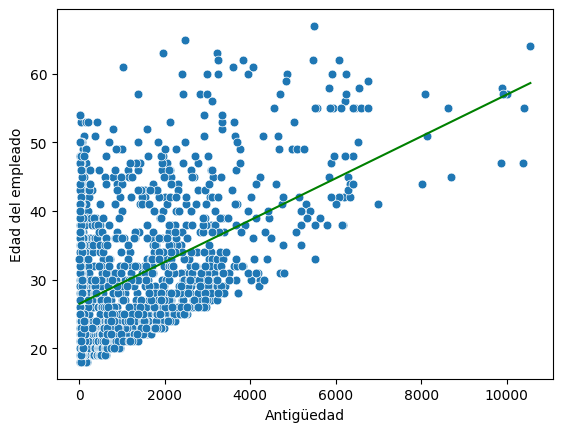

In [ ]:
sns.scatterplot(x=df_filtrado['Antigüedad'], y=df_filtrado['Edad del empleado'], s=40);
sns.lineplot(x=df_filtrado['Antigüedad'], y=y_predict, color='g');

In [ ]:
lr.score(df['Antigüedad'].to_frame(), df['Edad del empleado'])

0.2586137709574853

Podemos notar que nuestra R^2 es mas cercana al cero, asi que al parecer nuetsro modelo de regresion lineal no es muy bueno

#5. Distribuciones Muestrales y Técnicas de Evaluación de Modelos

In [ ]:
database = pd.read_csv('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.csv', index_col=0)

In [ ]:
database

,Posición,Area,Á.liq.,Grupo de personal,CODIGO POSTAL,Motivo de la RENUNCIA,Tipo de Baja,Banda,Baja,ReglaPHT,Alta,Antigüedad Clas,Antigüedad,Clave de sexo,Lugar de nacimiento,Clasificacion L. N,Edad del empleado,¿Cuanto tiempo tiene viviendo en Cd. Juarez?,Estado Civil,Hijos
ID,,,,,,,,,,,,,,,,,,,,
1,POS514,LOG,S6,Exempt,32520,Vol-Otro empleo,Voluntario,E3,02/01/2023,ADMINIST,21/06/2018,4 - 5 Años,1656,Femenino,JUAREZ,CIUDAD,31,Menos de un año,Soltero,0
2,POS1745,MFS,S5,Direct,32217,Vol-Otro empleo,Voluntario,DNO,03/01/2023,ADMINIST,20/07/2017,6 - 10 Años,1993,Masculino,DURANGO,PAIS,25,10+ Years,Soltero,0
3,POS1230,VS7,S5,Direct,32600,Vol-Otro empleo,Voluntario,DNO,03/01/2023,JT012324,29/08/2019,4 - 5 Años,1223,Masculino,JUAREZ,CIUDAD,23,10+ Years,Soltero,0
4,POS1661,MFS,S5,Direct,32575,Vol-Estudios,Voluntario,DO,03/01/2023,JT012324,03/11/2022,1 - 3 Años,61,Femenino,CIUDAD JUAREZ,CIUDAD,18,10+ Years,Soltero,0
5,POS1921,MFS,S5,Direct,32575,Vol-Cambio de domicilio,Voluntario,DO,03/01/2023,JT012324,02/03/2017,6 - 10 Años,2133,Masculino,JUAREZ,CIUDAD,26,10+ Years,Soltero,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,POS790,QMM,S6,Exempt,32585,Vol-Transferencia entre planta,Voluntario,E4,31/12/2022,ADMINIST,12/09/2011,10+ Años,4128,Masculino,MEXICO DF,PAIS,44,Menos de un año,Casado,0
1400,POS2802,TEF,S5,Direct,32575,Vol-Cambio de domicilio,Voluntario,DNO,26/07/2022,JT012324,05/08/2015,6 - 10 Años,2547,Masculino,JUAREZ,CIUDAD,28,Menos de un año,Soltero,0
1401,POS538,VS7,S5,Direct,32575,Vol-No regreso / no dio razón,Voluntario,DNO,02/09/2022,JT031800,21/07/2022,1 - 6 Meses,43,Femenino,CHIHUAHUA,ESTADO,21,Menos de un año,Soltero,0


In [ ]:
antiguedad_en_dias = database['Antigüedad']

Para hacer el analisis de muestreo y evaluación de datos, haremos uso de los datos referentes la antigúedad en días que llevan los empleados antes de renuncias, para entender si hay alguna relación entre la antigüedad de los empleados y las bajas.

In [ ]:
antiguedad_en_dias

ID
1       1656
2       1993
3       1223
4         61
5       2133
        ... 
1399    4128
1400    2547
1401      43
1402    1982
1403    3115
Name: Antigüedad, Length: 1403, dtype: int64

Aplicaremos un bootstaping a los datosm¿, contando con 1403 elementos, generamos un muestreo de los primeros 200 registros, esto, para que el proceso sea repetido 200 veces.

In [ ]:
# Crear una muestra de medias y calcular estadísticas descriptivas
means = []

for i in range(100_000):
    sample = antiguedad_en_dias.sample(n=200, replace=True)
    means.append(sample.mean())

means_antiguedad_en_dias = pd.Series(means)

Al presentar los datos obtenidos en el procedimiento aterior, se puede observar una distribución normal, y los valores son cercanos a 0.

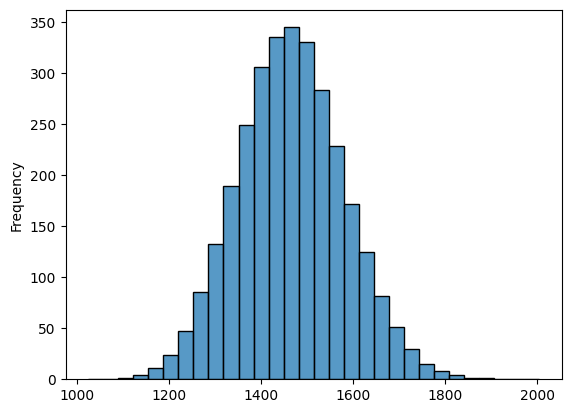

In [ ]:
#Utilizamos histplot en lugar de distplot
sns.histplot(means_antiguedad_en_dias, kde=False, stat="frequency", bins=30)

plt.show()

In [ ]:
print(f"Skey: {means_antiguedad_en_dias.skew()}")
print(f"Curtosis: {means_antiguedad_en_dias.kurtosis()}")
print(f"Error estándar: {means_antiguedad_en_dias.std()}")

Skey: 0.12632595448025188
Curtosis: 7.91588118294051e-05
Error estándar: 115.18494209326357


####Los resultados muestran lo siguiente:

* **Sesgo (Skewness)**
    Nuestro sesgo cercano a cero, nos indica que la distribución es aproximadamente simétrica, el sesgo positivo sugiere que la cola derecha de la distribución es ligeramente más larga que la izquierda.

* **Curtosis**
    Nuestro resultado de curtosis el cual es cercano a cero, nos indica que la distribución tiene colas moderadas y no es muy puntiaguda ni achatada.

* **Error estándar**
    Por ultimo, el resultado de error estándar nos proporciona una medida de la dispersión de las medias muestrales alrededor de la media de la distribución de las medias.


Simplificando los resultados, la distribución de las medias de la variable "Antigüedad en días" es relativamente simétrica y no muestra signos claros de colas pesadas o ligeras. El error estándar indica la dispersión típica de las medias muestrales.

In [ ]:
print(f'Valor mínimo: {means_antiguedad_en_dias.min()}')
print(f'Valor máximo: {means_antiguedad_en_dias.max()}')
print(f'Rango: {means_antiguedad_en_dias.max() - means_antiguedad_en_dias.min()}')

Valor mínimo: 1025.39
Valor máximo: 2004.28
Rango: 978.8899999999999


Estos valores proporcionan información sobre la variabilidad de las medias de la variable "Antigüedad en días".

* El rango es el resultado de la diferencia entre el valor máximo y el valor mínimo, nos indica que las medias de antigüedad en días, varían en un rango de días en las muestras de los 200 datos.

* Estos resultados son útiles para comprender la dispersión de las medias muestrales y proporcionan una indicación de la variabilidad en la antigüedad de los empleados en las muestras que han sido seleccionado en el análisis de muestreo.

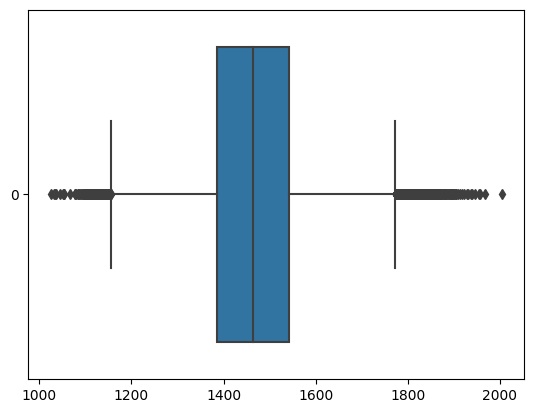

In [ ]:
sns.boxplot(means_antiguedad_en_dias, orient="h");

El boxplot e histograma re-afirman las observaciones anteriores, muestran un gran cúmulo de datos cercanos a la media (la línea en el medio de la caja es la mediana, que indica el valor central del conjunto de datos.) con una considerable cantidad de outliners (puntos individuales fuera de los bigotes, considerados valores atípicos).


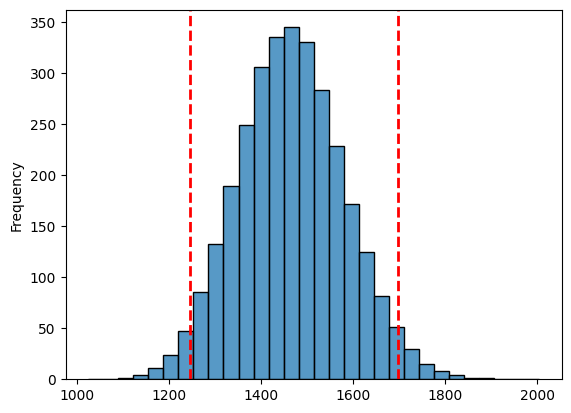

In [ ]:
limite_inferior = means_antiguedad_en_dias.quantile(0.025)
limite_superior = means_antiguedad_en_dias.quantile(0.975)

sns.histplot(means_antiguedad_en_dias, kde=False, stat="frequency", bins=30)
plt.axvline(limite_inferior, color='red', linestyle='dashed', linewidth=2)
plt.axvline(limite_superior, color='red', linestyle='dashed', linewidth=2);

Aquí, visualizamos las medias de la variable "Antigüedad en días" en un histograma y marcamos los límites inferior y superior de un intervalo de confianza del 95% con líneas verticales punteadas en rojo.

Este tipo de visualización es útil para evaluar la dispersión y la confiabilidad de las medias muestrales.

#6. Visualización de datos avanzada

Otra forma de vizualizar los Datos de Manera avanzada es con los **Treemaps**.

En esta ocacion se utilizan las categorias de **Clave de Sexo, Area, Grupo de Personal, y Banda**, para vizualizar como estan distribuidos segun el Genero del Personal.

Declaramos el df_agrupado con el fin de agrupar los datos en base a Clave sexo y ver la **DIVERSIDAD, TENDENCIAS SALARIALES Y EQUIDAD** que tenemos en los datos recolectados.

In [ ]:
df_agrupado = df.groupby('ID')[['Clave de sexo','Area','Grupo de personal','Banda' ]].max()

In [ ]:
df_agrupado.head(10)

,Clave de sexo,Area,Grupo de personal,Banda
ID,,,,
1,Femenino,LOG,Exempt,E3
2,Masculino,MFS,Direct,DNO
3,Masculino,VS7,Direct,DNO
4,Femenino,MFS,Direct,DO
5,Masculino,MFS,Direct,DO
6,Masculino,VS1,Direct,DNO
7,Femenino,VS9-ABS,Direct,DO
8,Femenino,MFS,Direct,DO
9,Masculino,TEF,Direct,DNO


**Sexo vs área**

In [ ]:
fig = px.treemap(df_agrupado, path=['Clave de sexo','Area'])
fig.show()#treemap por Area

**Sexo vs grupo de personal**

In [ ]:
fig = px.treemap(df_agrupado, path=['Clave de sexo','Grupo de personal'])
fig.show()#treemap por Grupo de personal

**Sexo vs banda**

In [ ]:
fig = px.treemap(df_agrupado, path=['Clave de sexo','Banda'])
fig.show()#treemap por Banda

#7. Procesamiento de Lenguaje Natural

En este apartado, realizaremos:
* Limpieza de NaNs y de strings
* Filtrado de locación
* Ordenamiento de datos

**Limpieza de NaNs**

Usando nuestra base de datos, hacemos una limpieza de NaNs

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.xlsx',names=nuevos_nombres)
df.head()

,Id,Posicion,Area,A_liq,Grupo_de_personal,Codigo_postal,Motivo_renuncia,Tipo_de_baja,Banda,Baja,...,Alta,Antiguedad_clas,Antiguedad,Clave_de_sexo,Lugar_de_nacimiento,Clasificacion_LN,Edad_empleado,Tiempo_viviendo_en_CdJuarez,Estado_civil,Hijos
0,1,514,7,2,2,32520,280,0,3,2023-01-02,...,2018-06-21,4,1656,0,JUAREZ,1,31,0,3,0
1,2,1745,8,1,1,32217,280,0,1,2023-01-03,...,2017-07-20,5,1993,1,DURANGO,3,25,10,3,0
2,3,1230,15,1,1,32600,280,0,1,2023-01-03,...,2019-08-29,4,1223,1,JUAREZ,1,23,10,3,0
3,4,1661,8,1,1,32575,230,0,2,2023-01-03,...,2022-11-03,1,61,0,JUAREZ,1,18,10,3,0
4,5,1921,8,1,1,32575,220,0,2,2023-01-03,...,2017-03-02,5,2133,1,JUAREZ,1,26,10,3,0


In [ ]:
df = df.dropna()
df.head(2)

,Id,Posicion,Area,A_liq,Grupo_de_personal,Codigo_postal,Motivo_renuncia,Tipo_de_baja,Banda,Baja,...,Alta,Antiguedad_clas,Antiguedad,Clave_de_sexo,Lugar_de_nacimiento,Clasificacion_LN,Edad_empleado,Tiempo_viviendo_en_CdJuarez,Estado_civil,Hijos
0,1,514,7,2,2,32520,280,0,3,2023-01-02,...,2018-06-21,4,1656,0,JUAREZ,1,31,0,3,0
1,2,1745,8,1,1,32217,280,0,1,2023-01-03,...,2017-07-20,5,1993,1,DURANGO,3,25,10,3,0


**Filtrado por localización**

Hacemos un filtro por localización del lugar de nacimiento de empleados que sean de Campeche

In [ ]:
nacimiento_df = pd.DataFrame({
    'Lugar_de_nacimiento': df['Lugar_de_nacimiento']
})
print(nacimiento_df)

     Lugar_de_nacimiento
0                 JUAREZ
1                DURANGO
2                 JUAREZ
3                 JUAREZ
4                 JUAREZ
...                  ...
1398           MEXICO DF
1399              JUAREZ
1400           CHIHUAHUA
1401            VERACRUZ
1402              JUAREZ

[1403 rows x 1 columns]


In [ ]:
resultado_filtrado = nacimiento_df[nacimiento_df['Lugar_de_nacimiento'].str.contains('CAMPECHE', case=False)]
resultado_filtrado

,Lugar_de_nacimiento
572,CAMPECHE
620,MIGUEL. A.C. CAMPECHE
745,CAMPECHE
1235,CAMPECHE
1362,CAMPECHE


**Limpieza de strings**

In [ ]:
df['Lugar_de_nacimiento'] = df['Lugar_de_nacimiento'].str.lower().str.strip().dropna()
print (df['Lugar_de_nacimiento'] )


0          juarez
1         durango
2          juarez
3          juarez
4          juarez
          ...    
1398    mexico df
1399       juarez
1400    chihuahua
1401     veracruz
1402       juarez
Name: Lugar_de_nacimiento, Length: 1403, dtype: object


**Ordenamiento de los datos**

Hicimos una suma de todas las listas para hacer una sola lista de todas las palabras de Lugar de nacimiento

In [ ]:
# Convertir a minúsculas y eliminar espacios en blanco al principio y al final
df['Lugar_de_nacimiento'] = df['Lugar_de_nacimiento'].str.lower().str.strip()

# Tokenizar cada fila y almacenar los resultados en una nueva columna llamada 'tokenized'
tokenized = df['tokenized'] = df['Lugar_de_nacimiento'].apply(word_tokenize)

# Eliminar filas que contengan valores NaN
df = df.dropna(subset=['Lugar_de_nacimiento'])

# Imprimir la nueva columna 'tokenized'
print(df['tokenized'])

0           [juarez]
1          [durango]
2           [juarez]
3           [juarez]
4           [juarez]
            ...     
1398    [mexico, df]
1399        [juarez]
1400     [chihuahua]
1401      [veracruz]
1402        [juarez]
Name: tokenized, Length: 1403, dtype: object


In [ ]:
all_words = tokenized.sum()
nacimiento_df = nltk.Text(all_words)
nacimiento_df # Creamos un objeto Text


<Text: juarez durango juarez juarez juarez juanacatlan juarez juarez...>

**Procesamiento y análisis de datos: Concordancia**

Para ver el contexto de la palabra Juárez usamos la función concordance.

In [ ]:
nacimiento_df.concordance('JUAREZ', lines=20)

Displaying 20 of 584 matches:
 juarez durango juarez juarez juarez juanac
juarez durango juarez juarez juarez juanacatlan juarez ju
juarez durango juarez juarez juarez juanacatlan juarez juarez ch
juarez durango juarez juarez juarez juanacatlan juarez juarez chihuahua
go juarez juarez juarez juanacatlan juarez juarez chihuahua juarez chihuahua s
ez juarez juarez juanacatlan juarez juarez chihuahua juarez chihuahua santa ba
juanacatlan juarez juarez chihuahua juarez chihuahua santa barbara durango jua
rez chihuahua santa barbara durango juarez juarez juarez juarez juarez juarez 
huahua santa barbara durango juarez juarez juarez juarez juarez juarez juarez 
santa barbara durango juarez juarez juarez juarez juarez juarez juarez tuxtla 
arbara durango juarez juarez juarez juarez juarez juarez juarez tuxtla gutierr
durango juarez juarez juarez juarez juarez juarez juarez tuxtla gutierrez guer
 juarez juarez juarez juarez juarez juarez juarez tuxtla gutierrez guerrero oa
 juarez juarez juare

**Similitud**

Usamos esta función para ver las palabras en contextos similares a Juárez

In [ ]:
nacimiento_df.similar('JUAREZ')

chihuahua veracruz durango oaxaca coahuila torreon tuxtepec minatitlan
zacatecas puebla tabasco mexico fresnillo chiapas delicias guerrero
chih juchitan guanajuato sinaloa


**Palabras más comunes**



In [ ]:
tokens = [word_tokenize(texto.lower()) for texto in df['Lugar_de_nacimiento']]
contador_palabras = Counter([palabra for lista_tokens in tokens for palabra in lista_tokens])
most_common_20 = np.array(list(map(lambda x: list(x), contador_palabras.most_common(20))))
print(most_common_20)

[['juarez' '584']
 ['chihuahua' '205']
 ['veracruz' '98']
 ['durango' '54']
 ['oaxaca' '40']
 ['coahuila' '31']
 ['torreon' '28']
 ['san' '22']
 [',' '18']
 ['tuxtepec' '18']
 ['de' '17']
 ['.' '14']
 ['gomez' '13']
 ['palacio' '11']
 ['mexico' '11']
 ['zacatecas' '11']
 ['chiapas' '11']
 ['del' '10']
 ['hidalgo' '10']
 ['puebla' '10']]


Se puede observar que la palabra más común es Juárez con un valor de 584 datos.

**Bigramas más comunes**

Usamos bigramas más comunes para encontrar los pares de palabras del lugar de nacimiento que aparecen con mayor frecuencia

In [ ]:
tokens = [word_tokenize(texto.lower()) for texto in df['Lugar_de_nacimiento']]

In [ ]:
bigramas = [bigrama for lista_tokens in tokens for bigrama in list(bigrams(lista_tokens))]
frecuencia_bigramas = FreqDist(bigramas)
bigramas_mas_comunes = frecuencia_bigramas.most_common(20)
bigramas_mas_comunes

[(('gomez', 'palacio'), 11),
 ((',', 'chih'), 7),
 (('distrito', 'federal'), 7),
 (('del', 'parral'), 6),
 (('hidalgo', 'del'), 5),
 (('san', 'lucas'), 5),
 (('lucas', 'ojitlan'), 5),
 (('san', 'pedro'), 4),
 (('de', 'zaragoza'), 4),
 (('chih', '.'), 4),
 (('santa', 'barbara'), 3),
 (('coah', '.'), 3),
 (('tres', 'valles'), 3),
 (('parral', ','), 3),
 (('san', 'andres'), 3),
 (('francisco', 'i'), 3),
 (('i', 'madero'), 3),
 ((',', 'coahuila'), 3),
 (('tuxtla', 'gutierrez'), 2),
 (('casas', 'grandes'), 2)]

**Longitud de las palabras**

Sacamos la longitud de palabras de los lugares de nacimiento de los empleados que renunciaron.

In [ ]:
df['Longitud_Palabras'] = [[len(palabra) for palabra in lista_tokens] for lista_tokens in tokens]

In [ ]:
print(df[['Lugar_de_nacimiento', 'Longitud_Palabras']])

     Lugar_de_nacimiento Longitud_Palabras
0                 juarez               [6]
1                durango               [7]
2                 juarez               [6]
3                 juarez               [6]
4                 juarez               [6]
...                  ...               ...
1398           mexico df            [6, 2]
1399              juarez               [6]
1400           chihuahua               [9]
1401            veracruz               [8]
1402              juarez               [6]

[1403 rows x 2 columns]


**Nube de palabras**

De manera más visual se pueden presentar los lugares de nacimiento a través de una nube de palabras, en donde más predomina la palabra Chihuahua y Juárez.

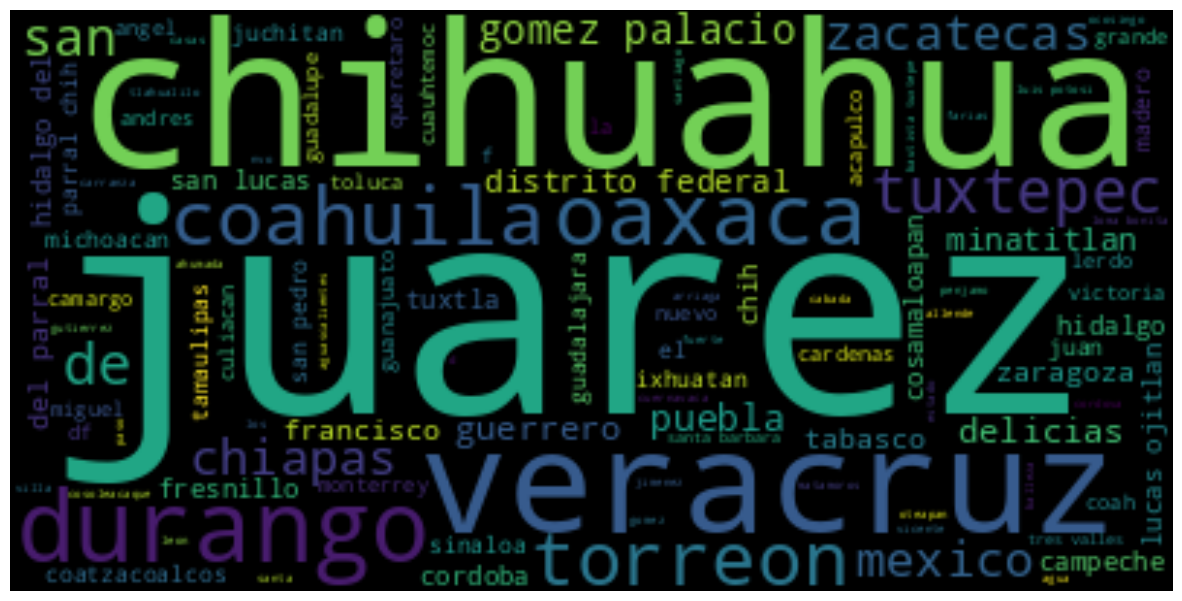

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=100, background_color="black").generate(' '.join(nacimiento_df))

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#8. Introducción a Machine Learning

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Proyecto_Bedu/DatathonBD.xlsx',names=nuevos_nombres)
df.head()

,Id,Posicion,Area,A_liq,Grupo_de_personal,Codigo_postal,Motivo_renuncia,Tipo_de_baja,Banda,Baja,...,Alta,Antiguedad_clas,Antiguedad,Clave_de_sexo,Lugar_de_nacimiento,Clasificacion_LN,Edad_empleado,Tiempo_viviendo_en_CdJuarez,Estado_civil,Hijos
0,1,514,7,2,2,32520,280,0,3,2023-01-02,...,2018-06-21,4,1656,0,JUAREZ,1,31,0,3,0
1,2,1745,8,1,1,32217,280,0,1,2023-01-03,...,2017-07-20,5,1993,1,DURANGO,3,25,10,3,0
2,3,1230,15,1,1,32600,280,0,1,2023-01-03,...,2019-08-29,4,1223,1,JUAREZ,1,23,10,3,0
3,4,1661,8,1,1,32575,230,0,2,2023-01-03,...,2022-11-03,1,61,0,JUAREZ,1,18,10,3,0
4,5,1921,8,1,1,32575,220,0,2,2023-01-03,...,2017-03-02,5,2133,1,JUAREZ,1,26,10,3,0


In [ ]:
df['Edad_empleado'].unique()

array([31, 25, 23, 18, 26, 38, 21, 27, 32, 41, 40, 33, 20, 24, 30, 45, 36,
       22, 48, 39, 42, 28, 47, 65, 37, 46, 53, 52, 34, 29, 57, 19, 60, 50,
       35, 51, 44, 56, 43, 49, 63, 62, 58, 55, 61, 54, 67, 64, 59])

In [ ]:
df['Edad_empleado'] = df['Edad_empleado'].replace({

})

In [ ]:
X = df.drop(columns=['Edad_empleado'])
y = df['Edad_empleado']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
logreg = LogisticRegression(max_iter=10_000)

Mean Squared Error (MSE): 42.38103338004665
R2 Score: 0.6038698945654684


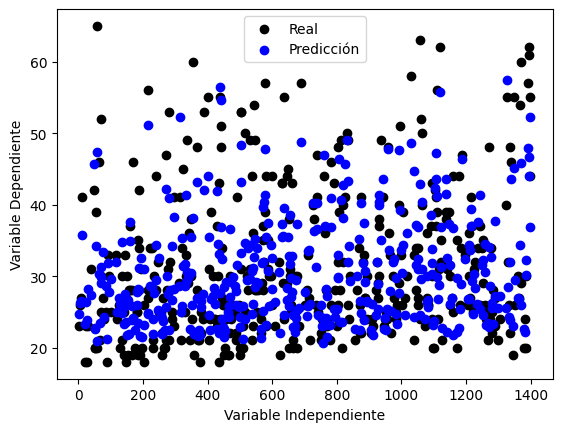

In [ ]:
#La variable categórica que queremos excluir es 'Lugar_de_nacimiento'
columns_to_exclude = ['Lugar_de_nacimiento']

#Excluimos columnas no numéricas y las columnas especificadas
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64']).drop(columns=columns_to_exclude, errors='ignore')
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64']).drop(columns=columns_to_exclude, errors='ignore')

# Verificar que haya al menos una muestra antes de ajustar el modelo
if X_train_numeric.shape[0] > 0:
    # Inicializar el modelo de regresión lineal con los datos limpios
    modelo_regresion = LinearRegression()
    modelo_regresion.fit(X_train_numeric, y_train)

    # Verificar que haya al menos una muestra antes de realizar predicciones
    if X_test_numeric.shape[0] > 0:
        # Realizar predicciones en el conjunto de prueba
        y_pred = modelo_regresion.predict(X_test_numeric)

        # Evaluar el rendimiento del modelo
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Imprimir métricas de rendimiento
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'R2 Score: {r2}')

        # Visualizar las predicciones vs los valores reales
        plt.scatter(X_test_numeric.iloc[:, 0], y_test, color='black', label='Real')  # Selecciona la primera columna para el eje x
        plt.scatter(X_test_numeric.iloc[:, 0], y_pred, color='blue', label='Predicción')
        plt.xlabel('Variable Independiente')
        plt.ylabel('Variable Dependiente')
        plt.legend()
        plt.show()
    else:
        print("No hay suficientes muestras en X_test para realizar predicciones.")
else:
    print("No hay suficientes muestras en X_train para ajustar el modelo.")

Los resultados proporcionados son métricas de evaluación del rendimiento de un modelo de regresión lineal aplicado a los datos de Clave sexo y lugar de Nacimiento.

* El MSE es 42.3810, lo que indica el promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales en el conjunto de prueba.

* El R2 Score es 0.6039, lo que sugiere que el modelo explica aproximadamente el 60.39% de la variabilidad en los datos.